# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [54]:
# !pip install datasets

Импорт необходимых библиотек

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ChernovNK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [7]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

c:\Users\ChernovNK\.conda\envs\One_power\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ChernovNK\.cache\huggingface\hub\datasets--ag_news. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downl

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ChernovNK\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [9]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 120000/120000 [00:11<00:00, 10026.15it/s]

Размер словаря: 11842


In [73]:
dataset['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [11]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [12]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [71]:
train_dataset[0]

{'text': [11712,
  6138,
  10418,
  10958,
  5585,
  4205,
  2712,
  11658,
  6509,
  3527,
  3527,
  5585,
  6138,
  8507,
  5585,
  7614,
  5585,
  4215,
  5095,
  1045,
  9474,
  1067],
 'label': 2}

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [13]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Запуск базовой модели с семинара на новом датасете (1 балл)

In [12]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [15]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [19]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

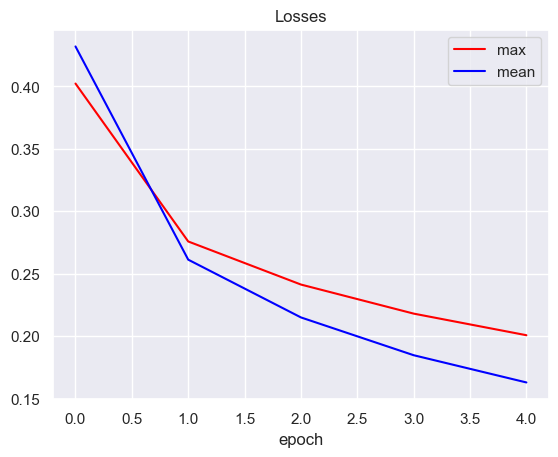

In [20]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.88
Лучшая accuracy для подхода mean: 90.84


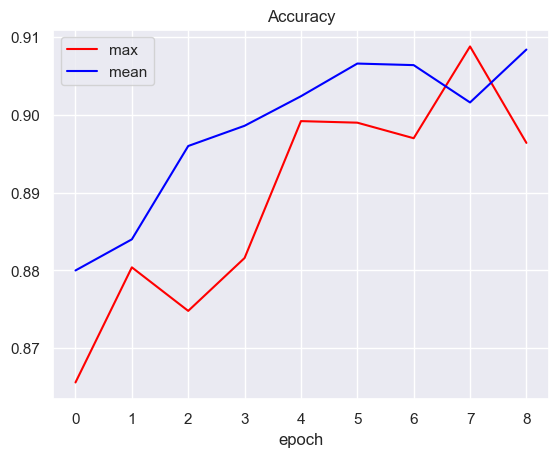

In [ ]:
# mean лучше
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

## Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)

GRU/LSTM

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        model_type: str = 'gru'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.model_type = model_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        if self.model_type == 'gru':
            output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        elif self.model_type == 'lstm':
            output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        else:
            # output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
            raise ValueError("Invalid model_type")

        output = output.mean(dim=1) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [25]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [26]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for model_type in ['gru', 'lstm']:
    print(f"Starting training for {model_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), num_classes=4, model_type=model_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[model_type] = losses
    acc_type[model_type] = acc

Starting training for gru


Training epoch 4:: 100%|██████████| 3750/3750 [00:40<00:00, 92.79it/s] 


Starting training for lstm


Training epoch 4:: 100%|██████████| 3750/3750 [00:41<00:00, 89.40it/s]


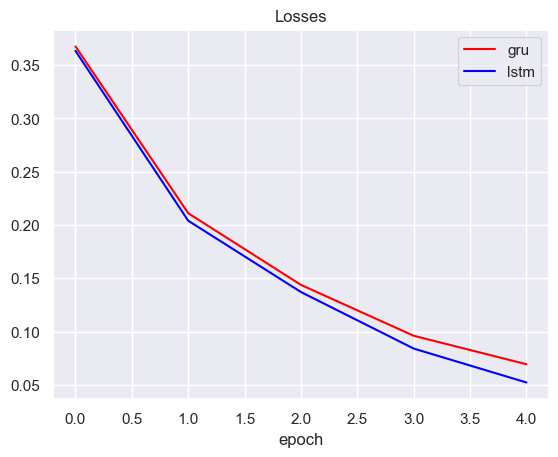

In [27]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода gru: 91.02
Лучшая accuracy для подхода lstm: 91.36


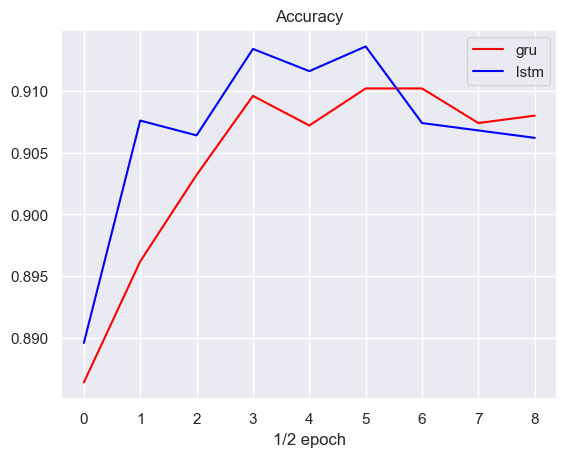

In [ ]:
# LSTM лучше
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("1/2 epoch")
plt.legend()
plt.show()

Сравниваем агрегацию всех таймстепов и только выход последнего момента и тестим двунаправленность

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        bi: bool = False, num: int = 1, agg = True
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=bi, num_layers=num)
        self.lstm_bi = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True, bidirectional=bi, num_layers=num)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.bi = bi
        self.num = num
        self.agg = agg

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        if self.bi:
            output, (hidden_n, _) = self.lstm_bi(embeddings)   # hidden_n = (num_layers * num_directions, batch_size, hidden_dim)
            if self.agg:
                output = output.mean(dim=1) #[batch_size, hidden_dim]
            else:
                # Объединяем скрытые состояния прямого и обратного проходов
                output = torch.cat((hidden_n[0], hidden_n[1]), dim=-1)
        else:
            output, (hidden_n, _) = self.lstm(embeddings)   # hidden_n = (num_layers * num_directions, batch_size, hidden_dim)
            if self.agg:
                output = output.mean(dim=1) #[batch_size, hidden_dim]
            else:
                # Последнее скрытое состояние
                output = hidden_n[-1]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [41]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [46]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for bidirectional in [True, False]:
    for aggregation in [True, False]:
        print(f"Starting training for bidirectional is {bidirectional} and aggregation is {aggregation}")
        losses = []
        acc = []
        bidir = 'BI_directional_' if bidirectional else 'ONE_directional_'
        agg = 'aggregation' if aggregation else 'without_aggregation'
        model = CharLM(
            hidden_dim=256, vocab_size=len(vocab), num_classes=4, bi=bidirectional, agg=agg).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    acc.append(evaluate(model, eval_dataloader))
                    model.train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[bidir+agg] = losses
        acc_type[bidir+agg] = acc

Starting training for bidirectional is True and aggregation is True


Training epoch 4:: 100%|██████████| 3750/3750 [00:49<00:00, 76.40it/s] 


Starting training for bidirectional is True and aggregation is False


Training epoch 4:: 100%|██████████| 3750/3750 [00:41<00:00, 90.75it/s] 


Starting training for bidirectional is False and aggregation is True


Training epoch 4:: 100%|██████████| 3750/3750 [00:42<00:00, 88.64it/s]


Starting training for bidirectional is False and aggregation is False


Training epoch 4:: 100%|██████████| 3750/3750 [00:42<00:00, 88.54it/s]


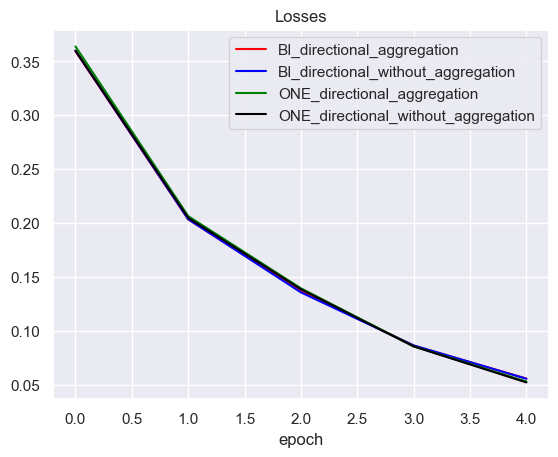

In [49]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue', 'green', 'black']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода BI_directional_aggregation: 91.72
Лучшая accuracy для подхода BI_directional_without_aggregation: 90.92
Лучшая accuracy для подхода ONE_directional_aggregation: 91.98
Лучшая accuracy для подхода ONE_directional_without_aggregation: 91.84


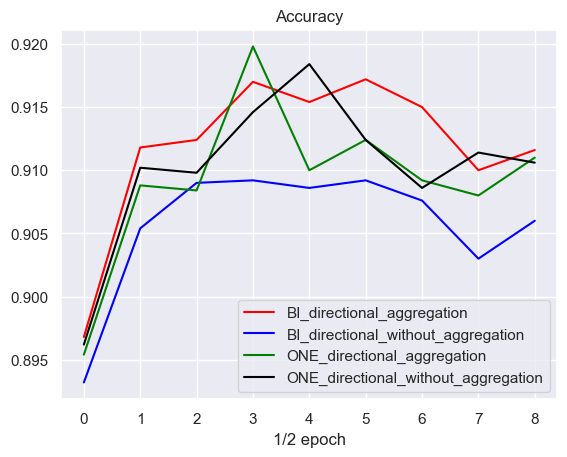

In [ ]:
# BI_directional_aggregation лучше 
for (name, values), color in zip(losses_type.items(), ['red', 'blue','green', 'black']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("1/2 epoch")
plt.legend()
plt.show()

Гиперапарметры: увеличим число слоев, эпох

In [58]:
# Слоев
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses = []
acc = []

model = CharLM(
    hidden_dim=256, vocab_size=len(vocab), num_classes=4, bi=True, num=2, agg=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

Training epoch 4:: 100%|██████████| 3750/3750 [00:49<00:00, 76.50it/s]


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24520\3953969607.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


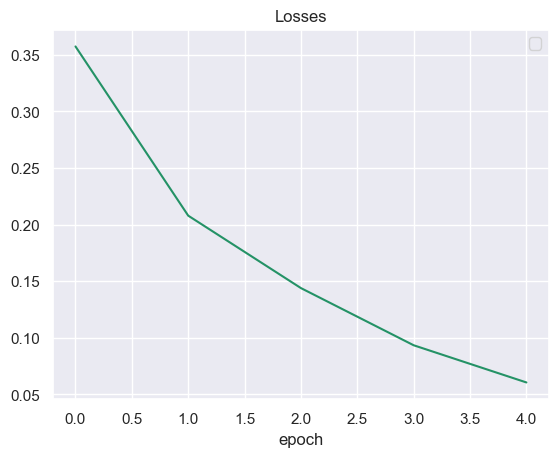

In [59]:
plt.plot(np.arange(len(losses)), losses)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24520\1124401463.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Лучшая accuracy: 91.44


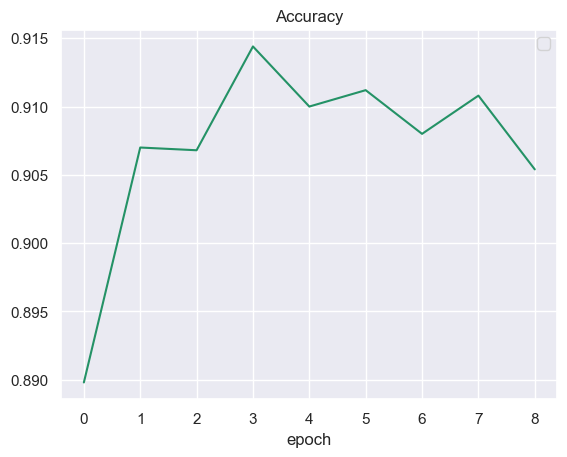

In [ ]:
# Нет прироста
plt.plot(np.arange(len(acc[1:])), acc[1:])
print(f"Лучшая accuracy: {(max(acc) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [64]:
# Эпох
num_epoch = 10
eval_steps = len(train_dataloader) // 2

losses = []
acc = []

model = CharLM(
    hidden_dim=256, vocab_size=len(vocab), num_classes=4, bi=True, num=1, agg=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

Training epoch 9:: 100%|██████████| 3750/3750 [01:15<00:00, 49.45it/s]


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24520\3953969607.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


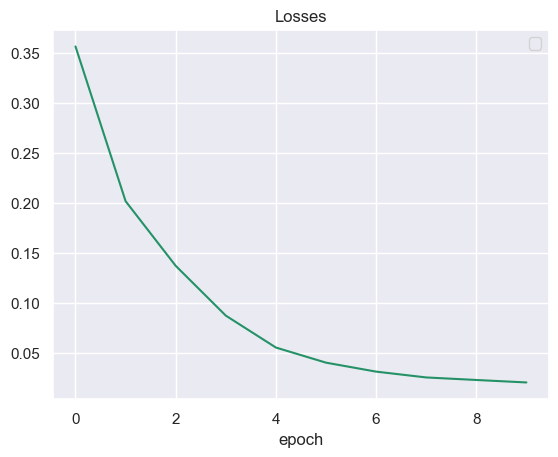

In [67]:
plt.plot(np.arange(len(losses)), losses)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.46


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24520\1124401463.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


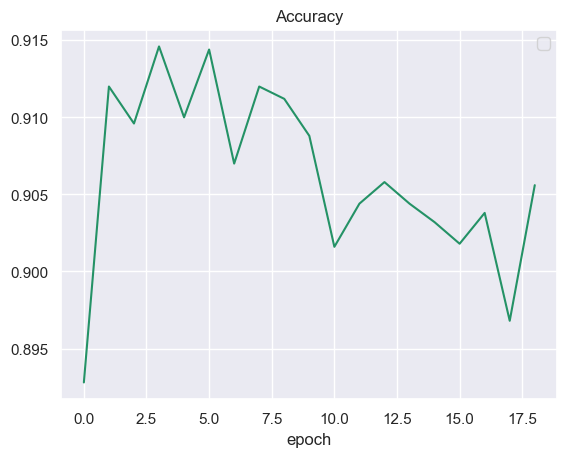

In [ ]:
# Нет прироста
plt.plot(np.arange(len(acc[1:])), acc[1:])
print(f"Лучшая accuracy: {(max(acc) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

Добавим предобученные эмбединги

In [78]:
from gensim.models import KeyedVectors

# Загружаем предобученные векторы
fasttext_path = 'wiki-news-300d-1M.vec'  # путь к файлу с эмбеддингами
wv = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)

hidden_dim = 300
vocab_size = len(vocab)

# создаём матрицу embedding
pretrained_matrix = np.random.normal(size=(vocab_size, hidden_dim)).astype(np.float32)

for word, idx in word2ind.items():
    if word in wv:
        pretrained_matrix[idx] = wv[word]
    # иначе оставляем случайный или нулевой вектор

# преобразуем в torch
pretrained_tensor = torch.from_numpy(pretrained_matrix)

In [79]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        bi: bool = False, num: int = 1, agg = True, pre = False
        ):
        super().__init__()
        # создаём embedding слой с предобученными весами

        self.embedding_pre = nn.Embedding.from_pretrained(pretrained_tensor, freeze=False, padding_idx=word2ind['<pad>'])

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=bi, num_layers=num)
        self.lstm_bi = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True, bidirectional=bi, num_layers=num)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.bi = bi
        self.num = num
        self.agg = agg
        self.pre = pre

    def forward(self, input_batch) -> torch.Tensor:

        if self.pre:
            embeddings = self.embedding_pre(input_batch)  # [batch_size, seq_len, hidden_dim]
        else:
            embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        if self.bi:
            output, (hidden_n, _) = self.lstm_bi(embeddings)   # hidden_n = (num_layers * num_directions, batch_size, hidden_dim)
            if self.agg:
                output = output.mean(dim=1) #[batch_size, hidden_dim]
            else:
                # Объединяем скрытые состояния прямого и обратного проходов
                output = torch.cat((hidden_n[0], hidden_n[1]), dim=-1)
        else:
            output, (hidden_n, _) = self.lstm(embeddings)   # hidden_n = (num_layers * num_directions, batch_size, hidden_dim)
            if self.agg:
                output = output.mean(dim=1) #[batch_size, hidden_dim]
            else:
                # Последнее скрытое состояние
                output = hidden_n[-1]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [81]:
# Слоев
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses = []
acc = []

model = CharLM(
    hidden_dim=300, vocab_size=len(vocab), num_classes=4, bi=True, num=1, agg=True, pre = True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model, eval_dataloader))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

Training epoch 4:: 100%|██████████| 3750/3750 [01:27<00:00, 42.82it/s]


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24520\4286228613.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


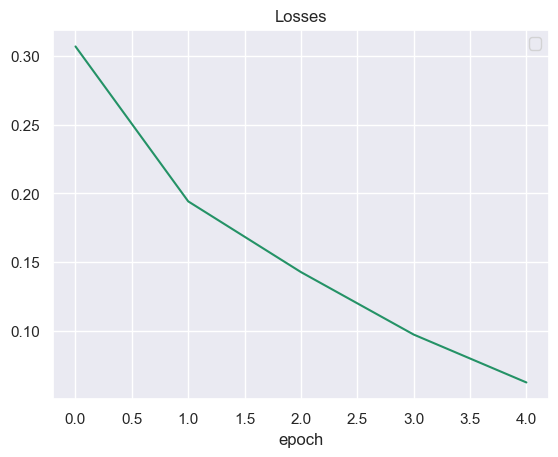

Лучшая accuracy: 91.78


C:\Users\ChernovNK\AppData\Local\Temp\ipykernel_24520\4286228613.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


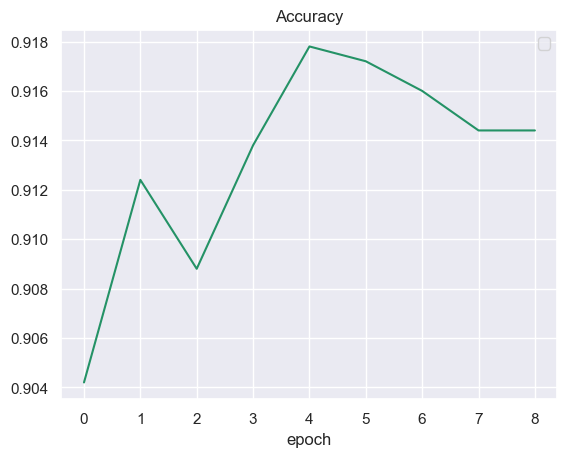

In [82]:
plt.plot(np.arange(len(losses)), losses)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

# 
plt.plot(np.arange(len(acc[1:])), acc[1:])
print(f"Лучшая accuracy: {(max(acc) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Краткий отчёт по экспериментам по текстовой классификации

## Обзор
Исследовали несколько архитектур и приёмов агрегации признаков по таймстепам. Цель — максимизировать accuracy на валидации.

## Результаты экспериментов (сводка)
| Эксперимент | Модель | Направление | Агрегация | Accuracy (%) | Заметки |
|---|---|---|---|---:|---|
| Pooling baseline (max) | — | — | max over timesteps | 90.88 | Чуть лучше mean |
| Pooling baseline (mean) | — | — | mean over timesteps | 90.84 | Почти равно max |
| GRU | GRU | one-directional | aggregation | 91.02 | Базовый рекуррентный вариант |
| LSTM | LSTM | one-directional | aggregation | 91.36 | Стабильно лучше GRU |
| Bi-LSTM + aggregation | LSTM | bi-directional | aggregation | 91.72 | Хорошо, но не лучшее |
| Bi-LSTM + last step | LSTM | bi-directional | last timestep | 90.92 | Агрегация помогает |
| **LSTM + aggregation (BEST)** | **LSTM** | **one-directional** | **aggregation** | **91.98** | **Лучший результат** |
| LSTM + last step | LSTM | one-directional | last timestep | 91.84 | Чуть хуже, чем с агрегацией |
| Bi-LSTM + aggregation (2 layers) | LSTM | bi-directional | aggregation | 91.44 | Меняли только глубину=2 |
| Bi-LSTM + aggregation (10 epochs) | LSTM | bi-directional | aggregation | 91.46 | Меняли только число эпох=10 |
| Bi-LSTM + aggregation + pretrained embeddings | LSTM | bi-directional | aggregation | 91.78 | Меняли только Embedding.from_pretrained |

## Анализ сходимости
- **Loss** убывает плавно, без резких скачков.
- **Accuracy** растёт ступенчато, колебания между эпохами малы (доли процента). Сходимость **стабильная**.
- Для варианта **BI\_directional + aggregation** кривая на графике почти везде лучше, и лишь в один момент её обошла кривая **ONE\_directional + aggregation**.
- Конфигурации без агрегации дают немного более «шумные» кривые, но общий тренд такой же.

## Выводы
- Переход **GRU → LSTM** дал небольшой, но устойчивый прирост.
- **Агрегация по всем таймстепам** лучше чтения только последнего скрытого состояния.
- Выбор **max vs mean** почти эквивалентен (max чуть впереди).
- **Bi-directional** в целом не превзошёл лучший one-directional; однако:
  - **Bi-LSTM (2 слоя): 91.44%**, **Bi-LSTM (5 эпох): 91.46%**, **Bi-LSTM + Embedding.from_pretrained: 91.78%** — во всех трёх экспериментах менялся **только один** гиперпараметр, остальные были **базовыми**.
  - Из этих трёх изменений самый заметный вклад дал **Embedding.from_pretrained** для Bi-LSTM (до **91.78%**).
- Оптимальной остаётся **one-directional LSTM с агрегацией**.

## Оптимальная модель
**LSTM (one-directional) с агрегацией по таймстепам**, валид. accuracy **≈ 91.98%**.